In [79]:
import matplotlib
import matplotlib.pyplot as plt
import signac
import gsd.fl
import gsd.hoomd
import numpy as np
from collections import OrderedDict

%matplotlib inline

#matplotlib.rc('xtick', labelsize=5) 
#matplotlib.rc('ytick', labelsize=5) 
#matplotlib.rc('axes', labelsize=2)
#matplotlib.rc('lines', linewidth=1)


#data_path = "/Users/mike/Data/stephen_data/sensitivity_analysis"
data_path = "/home/sthomas/projects/sensitivity_analysis/"
project = signac.get_project(data_path)
exp_data = np.load("exp_data.npz")
doc, pa, sa, ta = exp_data["arr_0"], exp_data["arr_1"], exp_data["arr_2"], exp_data["arr_3"]


{'sec_bond_weight': 1.2, 'dcd_write': 20000.0, 'curing_log_period': 100000.0, 'CC_bond_angle_const': None, 'shrink_time': 100000.0, 'shrinkT': 4.0, 'stop_after_percent': 100.0, 'T': 610.0, 'max_a_bonds': 4, 'old_init': False, 'bond': True, 'density': 1.0, 'AB_alpha': 1.0, 'bond_period': 10, 'AB_bond_const': 100.0, 'AC_interaction': 0.9026042322081145, 'profile_run': False, 'profile': 'ramp_up_and_down', 'calibrationT': 305.0, 'shrink': True, 'CC_bond_const': 100.0, 'AC_alpha': 1.0, 'BC_interaction': 0.9402127418834527, 'AB_interaction': 0.96, 't_SetT': 9500000.0, 'E_scale': 2536.49651, 'n_mul': 8000.0, 'activation_energy': 3.0, 'E_factor': 1.0, 'num_b': 20, 'BC_alpha': 1.0, 'n_particles': 400000.0, 'sim_name': 'blend_ramp_up_and_down_2.0kT', 'exclude_mixing_in_output': True, 'AB_bond_dist': 1.0, 'mix_kt': 4.0, 'AA_alpha': 1.0, 'trial': 0, 'pot': 'LangH', 'gamma': 4.5, 'num_a': 10, 'CC_interaction': 0.884, 't_Final': 10000000.0, 'num_c10': 2, 'nl_tuning': False, 'mix_dt': 0.0001, 'BB_in

on frame  50
on frame  100
on frame  150
on frame  200
on frame  250
on frame  300
on frame  350
on frame  400
on frame  450
on frame  500
on frame  550
on frame  600
on frame  650
on frame  700
on frame  750
on frame  800
on frame  850
on frame  900
on frame  950
on frame  1000
on frame  1050
on frame  1100
on frame  1150
on frame  1200
on frame  1250
on frame  1300
on frame  1350
on frame  1400
on frame  1450
on frame  1500
{'sec_bond_weight': 1.2, 'dcd_write': 20000.0, 'curing_log_period': 100000.0, 'CC_bond_angle_const': None, 'shrink_time': 100000.0, 'shrinkT': 4.0, 'pot': 'LangH', 'T': 610.0, 'max_a_bonds': 4, 'old_init': False, 'bond': True, 'density': 1.0, 'AB_alpha': 1.0, 'bond_period': 10, 'AB_bond_const': 100.0, 'AC_interaction': 0.9026042322081145, 'profile_run': False, 'profile': 'ramp_up_and_down', 'calibrationT': 305.0, 'trial': 2, 'CC_bond_const': 100.0, 'AC_alpha': 1.0, 'BC_interaction': 0.9402127418834527, 'AB_interaction': 0.96, 't_SetT': 2000000.0, 'E_scale': 2536.4

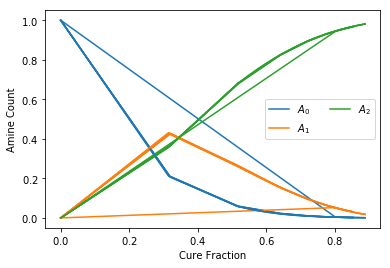

In [81]:
job_list = ["a52a2aacf366f4bfdb526c3c90a6e553", "4af7dd571c6f2e22547b5f23a9746507", "cfc1b2f7ae9559f94392f37a4d76046e",
           "d3d2dd9c78e669667bf9504b1b24abc5","c29d946191071e191c7e1f51ff9b6904","182c3bbc69b7021224feba09ac28010b"]
fig,ax1 = plt.subplots()

for job in project:
    if job._id in job_list:
        print(job.sp)
        
        kT = job.sp.temp_prof[-1][1]
        isdybond = job.sp.use_dybond_plugin is True
        isfrued = job.sp.use_dybond_plugin is False and job.sp.legacy_bonding is False
        
        #fig,ax1 = plt.subplots()#figsize=(14,11))
        #ax2 = ax1.twinx()
        print('final state points: {} time step, {} kT'.format(job.sp.temp_prof[-1][0],kT))
        print(job)
        
        f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
        t = gsd.hoomd.HOOMDTrajectory(f)
        n_frames = len(t)
        print('frames: ',n_frames)
        
        
        frames = []
        totalA = job.sp.n_mul*10 #A:B:C10 = 10:20:2
        frames.append(0)
        primaryA_cnts = []
        primaryA_cnts.append(totalA)
        secondaryA_cnts = []
        secondaryA_cnts.append(0)
        ternaryA_cnts = []
        ternaryA_cnts.append(0)
        quarternaryA_cnts = []
        quarternaryA_cnts.append(0)
        fivernaryA_cnts = []
        fivernaryA_cnts.append(0)
        otherA_cnts = []
        otherA_cnts.append(0)
        cure_fractions=[]
        cure_fractions.append(0)
        
        for i in range(0,n_frames,50):
            print("on frame ", i)
            bond_rank_dict = {}
            snapshot = t[i]
            #find how many repaeting indices are found in the bond table
            #print(snapshot.bonds.group)
            for pairs in snapshot.bonds.group:
                #print(pairs)
                for p in pairs:
                    ptype = snapshot.particles.typeid[p]
                    #print(ptype)
                    #print(p)
                    if ptype == 0:
                        if p in bond_rank_dict:
                            bond_rank_dict[p]+=1
                        else:
                            bond_rank_dict[p]=1
            #print(bond_rank_dict)
            
            #classify the repeating indices by type
            #count them to get primary Amines and epoxies
            primaryA_cnt=0;
            secondaryA_cnt=0
            ternaryA_cnt=0
            quarternaryA_cnt=0
            fivernaryA_cnt=0
            otherA_cnt=0
            #print(snapshot.particles.__dir__())
            for p in bond_rank_dict:
                if snapshot.particles.typeid[p] == 0: #if A
                    bond_cnt = bond_rank_dict[p]
                    if bond_cnt==1:
                        secondaryA_cnt+=1
                    elif bond_cnt==2:
                        ternaryA_cnt+=1
                    elif bond_cnt==3:
                        quarternaryA_cnt+=1
                    elif bond_cnt==4:
                        fivernaryA_cnt+=1
                    else:#if bond_cnt==5:
                        otherA_cnt+=1
                
            
            frames.append(i+1)
            
            total_bondedA = len(bond_rank_dict)
            primaryA_cnt = totalA-total_bondedA
            #print('totalA:',totalA,'total bondedA:',total_bondedA,'primaryA:',primaryA_cnt)
            totalA_bonds_made = sum(bond_rank_dict.values())
            total_possible_A_bonds = totalA*4
            cure_fractions.append(totalA_bonds_made/total_possible_A_bonds)
            primaryA_cnts.append(primaryA_cnt) 
            secondaryA_cnts.append(secondaryA_cnt) 
            ternaryA_cnts.append(ternaryA_cnt) 
            quarternaryA_cnts.append(quarternaryA_cnt) 
            fivernaryA_cnts.append(fivernaryA_cnt)
            otherA_cnts.append(otherA_cnt)
            
        bondmethod = 'dybond'
        if isdybond is False:
            bondmethod = 'freud'
            
        legend = '{} kT, bond weight:{}'.format(job.sp.temp_prof[-1][1],job.sp.sec_bond_weight)
        frames=np.asarray(frames)
        ##plt.plot(data[:,0],data[:,1],marker='o',label='curing @{}'.format(legend))
        #l1=ax1.plot(frames*job.sp.dcd_write,primaryA_cnts,marker='o',markersize=12,label='$A_0$')#primary amine')
        #l2=ax1.plot(frames*job.sp.dcd_write,secondaryA_cnts,marker='s',markersize=12,label='$A_1$')#'secondary amine')
        #l3=ax1.plot(frames*job.sp.dcd_write,ternaryA_cnts,marker='*',markersize=12,label='$A_2$')#'ternary amine')
        #l4=ax1.plot(frames*job.sp.dcd_write,quarternaryA_cnts,marker='P',markersize=12,label='$A_3$')#'quarternary amine')
        #l5=ax1.plot(frames*job.sp.dcd_write,fivernaryA_cnts,marker='D',markersize=12,label='$A_4$')#'quinary amine')
        ##ax1.plot(frames,otherA_cnts,marker='o',label='other amine')
        #l6=ax2.plot(frames*job.sp.dcd_write,cure_fractions,linestyle='--',label='cure fraction')
        ##print(bonding_method, 'cure fraction', cure_fractions[-1])
        
        primaryA_cnts = np.asarray(primaryA_cnts)
        secondaryA_cnts = np.asarray(secondaryA_cnts)
        ternaryA_cnts = np.asarray(ternaryA_cnts)
        quarternaryA_cnts = np.asarray(quarternaryA_cnts)
        fivernaryA_cnts = np.asarray(fivernaryA_cnts)
        scale_factor = primaryA_cnts[0]
        
        primaryA_cnts=primaryA_cnts/scale_factor
        secondaryA_cnts=secondaryA_cnts/scale_factor
        ternaryA_cnts=ternaryA_cnts/scale_factor
        quarternaryA_cnts=quarternaryA_cnts/scale_factor
        fivernaryA_cnts=fivernaryA_cnts/scale_factor
        
        
        ternaryA_cnts = ternaryA_cnts + quarternaryA_cnts + fivernaryA_cnts
        
        
        ax1.plot(cure_fractions,primaryA_cnts, label='$A_0$', color='#1f77b4')
        ax1.plot(cure_fractions,secondaryA_cnts, label='$A_1$', color='#ff7f0e')
        ax1.plot(cure_fractions,ternaryA_cnts, label='$A_2$', color='#2ca02c')
        #ax1.plot(doc,pa, label='exp 0', color='#1f77b4', linestyle='--')
        #ax1.plot(doc,sa, label='exp 1', color='#ff7f0e', linestyle='--')
        #ax1.plot(doc,ta, label='exp 2', color='#2ca02c', linestyle='--')
        #ax1.plot(cure_fractions,quarternaryA_cnts, label='$A_3$')
        #ax1.plot(cure_fractions,fivernaryA_cnts, label='$A_4$')

        #plot_lines.append([l1, l2, l3, l4, l5, l6])
        kTs = [1]
        activation_energy = 1
        weights = [1]
        for weight in weights:
            legend = 'weight:{}'.format(weight)
            #plot_bonding(kTs, activation_energy,no_weights=False,time=5e6,show_all=False,weight=weight,show_figure=False,legend=legend)


        #ax1.set_xlabel('Time Steps',fontsize=50)
        #ax1.set_ylabel('Amine Count',fontsize=50)
        #ax2.set_ylabel('Cure Fraction',fontsize=50)
        ax1.set_xlabel('Cure Fraction')
        ax1.set_ylabel('Amine Count')
        #ax2.set_ylabel('Cure Fraction',fontsize=50)
        #ax2.set_ylim(0,1)
        ##plt.ylim(0,100)
        
        #ax1.legend(loc='best',ncol=2)
        #ax2.legend(fontsize=50,loc='upper left')
        ax1.xaxis.major.formatter._useMathText = True
        ax1.yaxis.major.formatter._useMathText = True
        #ax1.set_ylim(0,1.0e4)
        ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
        ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True) 
        #plt.title(bondmethod,fontsize=20)
# Remove dups in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best',ncol=2)
plt.show()
    

In [65]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
